In [1]:
import h5py
import time
import argparse
import numpy as np
import scipy.io as sio
from copy import deepcopy
from einops import rearrange
import matplotlib.pyplot as plt


import torch
import torch.nn as nn
from torch import optim
import torch.utils.data as Data
import torch.nn.functional as F
from torchsummary import summary
import torch.backends.cudnn as cudnn


from sklearn.decomposition import PCA
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import StandardScaler

from auxiliary_classifier import CapsGLOM

from data_prepare import mirror_hsi
from data_prepare import choose_train_and_test_number
from data_prepare import choose_train_and_test_proportion
from data_prepare import train_and_test_data, train_and_test_label

from auxiliary_classifier import auxiliary_test_epoch
from auxiliary_classifier import auxiliary_train_epoch
from auxiliary_classifier import auxiliary_valid_epoch


from Utils import ActivationOutputData
from Utils import output_metric, plot_confusion_matrix
from Utils import train_epoch, test_epoch, valid_epoch
from Utils import list_to_colormap, classification_map, print_args


%matplotlib inline

In [2]:
parser = argparse.ArgumentParser("Caps-Transformer")
parser.add_argument('--dataset', choices=['Chikusei', 'Pavia', 'KSC', 'HU2013'], default='KSC', help='dataset to use')
parser.add_argument('--flag_test', choices=['test', 'train'], default='train', help='testing mark')
parser.add_argument('--gpu_id', default='0', help='GPU id')
parser.add_argument('--seed', type=int, default=0, help='number of seed')
parser.add_argument('--batch_size', type=int, default=32, help='number of batch size')
parser.add_argument('--patch_size', type=int, default=25, help='size of patches')
parser.add_argument('--epoches', type=int, default=200, help='epoch number')
parser.add_argument('--learning_rate', type=float, default=1e-3, help='learning rate')
parser.add_argument('--gamma', type=float, default=0.99, help='gamma')
parser.add_argument('--train_number', type=int, default=1, help='num_train_per_class')
parser.add_argument('--train_proportion', type=float, default=0.05, help='num_train_per_class')
args = parser.parse_args(args=[])

In [4]:
# prepare data
if args.dataset == 'Chikusei':
    data = h5py.File('./dataset/Chikusei.mat', 'r')['chikusei']
    data = np.array(data)
    data = np.transpose(data, (2, 1, 0))
    label = sio.loadmat('./dataset/Chikusei_gt.mat')['GT'][0][0][0]
elif args.dataset == 'HU2013':
    data = sio.loadmat('./dataset/Houston.mat')['Houston']
    label = sio.loadmat('./dataset/Houston_gt.mat')['Houston_gt']
elif args.dataset == 'Pavia':
    data = sio.loadmat('./dataset/PaviaU.mat')['paviaU']
    label = sio.loadmat('./dataset/PaviaU_gt.mat')['paviaU_gt']
elif args.dataset == 'KSC':
    data = sio.loadmat('./dataset/KSC.mat')['KSC']
    label = sio.loadmat('./dataset/KSC_gt.mat')['KSC_gt']
else:
    raise ValueError("Unknown dataset")
    
num_classes = np.max(label)
print('The class numbers of the HSI data is:', num_classes)

The class numbers of the HSI data is: 13


In [ ]:
shapeor = data.shape
data = data.reshape(np.prod(data.shape[:2]), np.prod(data.shape[2:]))

std_scaler = StandardScaler()
std_data = std_scaler.fit_transform(data)
data = std_data.reshape(shapeor)

In [5]:
total_pos_train, total_pos_test, total_pos_true, number_train, number_test, number_true = \
choose_train_and_test_proportion(label, args.train_proportion)
#  Don't forget to modify the choose_train_and_test_proportion function in the data_prepare module.

In [6]:
def applyPCA(X, numComponents=75):
    newX = np.reshape(X, (-1, X.shape[2]))
    pca = PCA(n_components=numComponents, whiten=True)
    newX = pca.fit_transform(newX)
    newX = np.reshape(newX, (X.shape[0], X.shape[1], numComponents))
    return newX, pca

In [7]:
K = 15
data, pca = applyPCA(data, numComponents=K)

# data size
height, width, band = data.shape
print("height={0}, width={1}, band={2}".format(height, width, band))

height=512, width=614, band=15


In [8]:
mirror_data = mirror_hsi(height, width, band, data, patch_size=args.patch_size)

x_train, x_test, x_true = train_and_test_data(mirror_data, band, total_pos_train, total_pos_test, 
                                              total_pos_true, patch_size=args.patch_size)

y_train, y_test, y_true = train_and_test_label(number_train, number_test, number_true, num_classes)

**************************************************
patch_size is : 25
mirror_data shape : [536, 638, 15]
**************************************************
x_train shape = (268, 25, 25, 15), type = float64
x_test  shape = (4943, 25, 25, 15), type = float64
x_true  shape = (5211, 25, 25, 15), type = float64
**************************************************
y_train: shape = (268,), type = int64
y_test: shape = (4943,), type = int64
y_true: shape = (5211,), type = int64
**************************************************


In [9]:
# load data
x_train = torch.from_numpy(x_train).unsqueeze(1).type(torch.FloatTensor)
print(x_train.shape)
y_train = torch.from_numpy(y_train).type(torch.LongTensor)  # (13,)
Train_Label = Data.TensorDataset(x_train, y_train)

x_test = torch.from_numpy(x_test).unsqueeze(1).type(torch.FloatTensor)
print(x_test.shape)
y_test = torch.from_numpy(y_test).type(torch.LongTensor)  # (5198,)
Test_Label = Data.TensorDataset(x_test, y_test)

x_true = torch.from_numpy(x_true).unsqueeze(1).type(torch.FloatTensor)
print(x_true.shape)
y_true = torch.from_numpy(y_true).type(torch.LongTensor)
True_Label = Data.TensorDataset(x_true, y_true)

train_loader = Data.DataLoader(Train_Label, batch_size=args.batch_size, shuffle=True)
test_loader = Data.DataLoader(Test_Label, batch_size=args.batch_size, shuffle=True)
true_loader = Data.DataLoader(True_Label, batch_size=100, shuffle=False)

torch.Size([268, 1, 25, 25, 15])
torch.Size([4943, 1, 25, 25, 15])
torch.Size([5211, 1, 25, 25, 15])


## Model

In [10]:
class HybridSN(nn.Module):
    def __init__(self, num_classes=13):
        super(HybridSN, self).__init__()
        self.conv_layer1 = nn.Conv3d(in_channels=1, out_channels=8, kernel_size=(3, 3, 7))
        self.conv_layer2 = nn.Conv3d(8, 16, kernel_size=(3, 3, 5))
        self.conv_layer3 = nn.Conv3d(16, 32, kernel_size=(3, 3, 3))
        self.relu = nn.ReLU()
        
        self.conv_layer4 = nn.Conv2d(96, 64, kernel_size=(3, 3))

        self.dense_layer1 = nn.Sequential(
            nn.Linear(18496, 256),
            nn.ReLU(),
            nn.Dropout(0.4)
        )
        self.dense_layer2 = nn.Sequential(
            nn.Linear(256, 128), 
            nn.ReLU(),
            nn.Dropout(0.4)
        )
        self.out_layer = nn.Linear(128, num_classes)
        
    def forward(self, x):
        x = self.relu(self.conv_layer1(x))
        x = self.relu(self.conv_layer2(x))
        x = self.relu(self.conv_layer3(x))
        x = rearrange(x, 'b c h w d -> b (c d) h w')
        x = self.relu(self.conv_layer4(x))
        x = rearrange(x, 'b c h w -> b (c h w)') 
        x = self.dense_layer1(x)
        x = self.dense_layer2(x)
        x = self.out_layer(x)
        return x

In [11]:
net = HybridSN(num_classes).cuda()

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=1e-3, betas=(0.9, 0.999), eps=1e-8, weight_decay=1e-06)
scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=args.gamma)
# scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, 15, eta_min=0.0, last_epoch=-1)

In [12]:
tic = time.time()
for epoch in range(args.epoches):
    # train model
    net.train()
    # 计算的是移动平均准确率
    train_acc, train_obj, tar_train, pre_train = auxiliary_train_epoch(net, train_loader, criterion, optimizer)
    OA_trian, AA_mean_train, Kappa_train, AA_train = output_metric(tar_train, pre_train)
    print("Epoch: {:03d} train_loss: {:.4f} train_acc: {:.4f}".format(epoch+1, train_obj, train_acc))
    scheduler.step()
    
toc = time.time()
print("Running Time: {:.2f}".format(toc-tic))
print("**************************************************")

Epoch: 001 train_loss: 2.4878 train_acc: 16.0448
Epoch: 002 train_loss: 2.3667 train_acc: 20.1493
Epoch: 003 train_loss: 2.2679 train_acc: 27.6119
Epoch: 004 train_loss: 2.1185 train_acc: 27.2388
Epoch: 005 train_loss: 1.9862 train_acc: 33.9552
Epoch: 006 train_loss: 1.7326 train_acc: 40.2985
Epoch: 007 train_loss: 1.6274 train_acc: 39.1791
Epoch: 008 train_loss: 1.5319 train_acc: 45.5224
Epoch: 009 train_loss: 1.3408 train_acc: 54.8507
Epoch: 010 train_loss: 1.3128 train_acc: 56.3433
Epoch: 011 train_loss: 1.2601 train_acc: 57.4627
Epoch: 012 train_loss: 1.1834 train_acc: 60.8209
Epoch: 013 train_loss: 1.0272 train_acc: 66.0448
Epoch: 014 train_loss: 0.9345 train_acc: 67.1642
Epoch: 015 train_loss: 1.0074 train_acc: 66.0448
Epoch: 016 train_loss: 0.7948 train_acc: 72.3881
Epoch: 017 train_loss: 0.8190 train_acc: 70.5224
Epoch: 018 train_loss: 0.7061 train_acc: 73.5075
Epoch: 019 train_loss: 0.7435 train_acc: 73.8806
Epoch: 020 train_loss: 0.6775 train_acc: 74.6269
Epoch: 021 train_los

Epoch: 169 train_loss: 0.0401 train_acc: 99.2537
Epoch: 170 train_loss: 0.0073 train_acc: 100.0000
Epoch: 171 train_loss: 0.0085 train_acc: 99.6269
Epoch: 172 train_loss: 0.0166 train_acc: 99.6269
Epoch: 173 train_loss: 0.0101 train_acc: 99.6269
Epoch: 174 train_loss: 0.0108 train_acc: 99.6269
Epoch: 175 train_loss: 0.0092 train_acc: 99.6269
Epoch: 176 train_loss: 0.0060 train_acc: 100.0000
Epoch: 177 train_loss: 0.0129 train_acc: 99.6269
Epoch: 178 train_loss: 0.0022 train_acc: 100.0000
Epoch: 179 train_loss: 0.0177 train_acc: 99.6269
Epoch: 180 train_loss: 0.0088 train_acc: 100.0000
Epoch: 181 train_loss: 0.0067 train_acc: 99.6269
Epoch: 182 train_loss: 0.0036 train_acc: 100.0000
Epoch: 183 train_loss: 0.0119 train_acc: 99.6269
Epoch: 184 train_loss: 0.0031 train_acc: 100.0000
Epoch: 185 train_loss: 0.0041 train_acc: 100.0000
Epoch: 186 train_loss: 0.0037 train_acc: 100.0000
Epoch: 187 train_loss: 0.0099 train_acc: 99.6269
Epoch: 188 train_loss: 0.0022 train_acc: 100.0000
Epoch: 189 

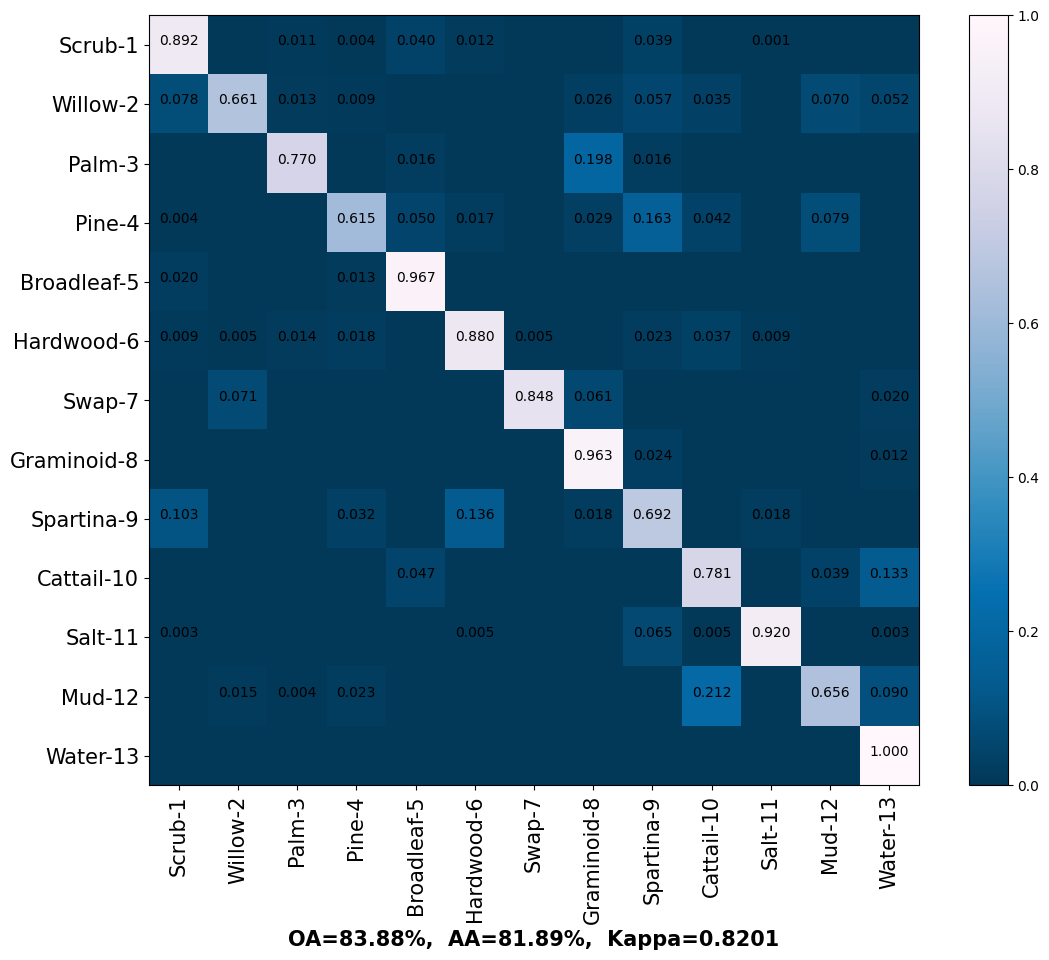

**************************************************
Final result:
OA: 83.88% | AA: 81.89% | Kappa: 0.8201
[0.89196676 0.66086957 0.76954733 0.61506276 0.96710526 0.88018433
 0.84848485 0.96332518 0.69230769 0.78067885 0.91959799 0.65618449
 1.        ]
**************************************************
Parameter:
dataset: KSC
flag_test: train
gpu_id: 0
seed: 0
batch_size: 32
patch_size: 25
epoches: 200
learning_rate: 0.001
gamma: 0.99
train_number: 1
train_proportion: 0.05
**************************************************


In [13]:
net.eval()
tar_test, pre_test = auxiliary_test_epoch(net, test_loader)  # 收集所有真实标签和预测标签(np.array)
OA_test, AA_mean_test, Kappa_test, AA_test = output_metric(tar_test, pre_test)

# output classification maps
pre_u = auxiliary_valid_epoch(net, true_loader)
prediction_matrix = np.zeros((height, width), dtype=float)  # (512, 614)
for i in range(total_pos_true.shape[0]):
    prediction_matrix[total_pos_true[i, 0], total_pos_true[i, 1]] = pre_u[i] + 1
cm = confusion_matrix(tar_test, pre_test)
plot_confusion_matrix(args.dataset, cm, path='./Confusion_Map_HybridSN.pdf')

print("**************************************************")
print("Final result:")
print("OA: {:.2f}% | AA: {:.2f}% | Kappa: {:.4f}".format(OA_test * 100., AA_mean_test*100., Kappa_test))
print(AA_test)
print("**************************************************")
print("Parameter:")
print_args(vars(args))
print("**************************************************")

In [14]:
average_accuracy = str(AA_test)
file_name = "classification_report.txt"

with open(file_name, 'w') as x_file:
    x_file.write("OA: {:.2f}% | AA: {:.2f}% | Kappa: {:.4f}".format(OA_test * 100., AA_mean_test*100., Kappa_test))
    x_file.write('\n')
    x_file.write('{}'.format(average_accuracy))